# Arctic-calibrated Brunt equation

## Jason Kniss
## Feb 14 2024

### Calibrate the Brunt equation using data from the Eureka site

Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

## Import data from Eureka observatory

In [2]:
towermet_07012011_file = 'data/eureka-data/eurmeteorologicaltwr.b1.20110701.000000.txt'
# Add additional tower met data files

towerrad_07012011_file = 'data/eureka-data/eurradiationtwr.b1.20110701.000000.txt'
# Add additional tower radiation files

### Create meteorological dataframes

Extract the header data separately (delimiters are not the same)

In [3]:
with open(towermet_07012011_file, "r") as f:
    lines = f.readlines()

header = lines[0].strip().split()
data_rows = [line.strip().split("\t") for line in lines[1:]]


In [4]:
df1 = pd.DataFrame(data_rows, columns=header)
 # Rename the dataframe when more data is imported

In [5]:
df1 = df1.astype('float')

In [6]:
df1.head()

,DayFrac,Year,JulianDay,HourMin,Pressure[mbar],10MVTair[degC],10MRH[%],6MVTair[degC],6MRH[%],2MVTair[degC],...,2MTair[degC],10MTCETair[degC],6MTCETair[degC],6MTCWTair[degC],2MTCWTair[degC],Wdir[deg],Wspd[m/s],HumidityQC,AirTempQC,TCAirTempQC
0,182.000,2011.0,182.0,0.0,1006.3,18.695,22.882,18.781,23.215,18.933,...,18.346,19.155,19.320,19.481,-9999.0,176.99,2.6605,0.0,0.0,1.0
1,182.001,2011.0,182.0,1.0,1006.4,18.719,23.086,18.856,23.790,18.990,...,18.392,19.351,19.578,19.562,-9999.0,195.14,1.9895,0.0,0.0,1.0
2,182.001,2011.0,182.0,2.0,1006.4,18.802,23.171,18.892,23.560,19.018,...,18.406,19.430,19.517,19.658,-9999.0,180.96,2.0947,0.0,0.0,1.0
3,182.002,2011.0,182.0,3.0,1006.4,18.793,22.865,18.861,23.263,18.985,...,18.389,19.124,19.244,19.377,-9999.0,165.34,2.3053,0.0,0.0,1.0
4,182.003,2011.0,182.0,4.0,1006.4,18.691,22.890,18.768,23.457,18.933,...,18.341,19.227,19.421,19.453,-9999.0,160.13,2.1737,0.0,0.0,1.0


In [7]:
df1.describe()

,DayFrac,Year,JulianDay,HourMin,Pressure[mbar],10MVTair[degC],10MRH[%],6MVTair[degC],6MRH[%],2MVTair[degC],...,2MTair[degC],10MTCETair[degC],6MTCETair[degC],6MTCWTair[degC],2MTCWTair[degC],Wdir[deg],Wspd[m/s],HumidityQC,AirTempQC,TCAirTempQC
count,1440.000000,1440.0,1440.0,1440.00000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,...,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,182.499656,2011.0,182.0,1179.50000,1005.749583,18.146654,25.146140,18.314465,25.534051,18.414520,...,17.843102,18.503231,18.614147,18.398411,-9950.298996,193.301083,3.003553,733.811111,0.785417,4.064583
std,0.288777,0.0,0.0,692.67581,0.287255,1.010456,4.624364,0.978427,4.494879,1.074884,...,1.140793,1.016766,1.034999,1.422710,697.048249,52.581495,1.764908,8450.125618,8.981592,52.898496
min,182.000000,2011.0,182.0,0.00000,1005.200000,15.393000,16.836000,15.619000,17.281000,15.522000,...,14.819000,16.038000,15.994000,14.397000,-9999.000000,124.210000,0.200000,0.000000,0.000000,0.000000
25%,182.249750,2011.0,182.0,589.75000,1005.500000,17.884000,22.185250,18.042500,22.783000,18.050250,...,17.358000,17.769000,17.933000,17.865250,-9999.000000,159.767500,1.686800,0.000000,0.000000,1.000000
50%,182.499500,2011.0,182.0,1179.50000,1005.800000,18.315500,24.222000,18.514500,24.609000,18.602500,...,18.012000,18.596000,18.701500,18.749500,-9999.000000,170.580000,2.410500,0.000000,0.000000,1.000000
75%,182.749250,2011.0,182.0,1769.25000,1005.900000,18.870250,27.284000,18.993750,27.571000,19.235500,...,18.731500,19.376000,19.473500,19.487250,-9999.000000,212.877500,4.384200,0.000000,0.000000,1.000000
max,182.999000,2011.0,182.0,2359.00000,1006.400000,19.884000,36.965000,19.998000,37.092000,20.281000,...,19.825000,20.250000,20.489000,20.401000,19.711000,352.260000,7.568400,110011.000000,111.000000,1001.000000


In [8]:
df1.columns

Index(['DayFrac', 'Year', 'JulianDay', 'HourMin', 'Pressure[mbar]',
       '10MVTair[degC]', '10MRH[%]', '6MVTair[degC]', '6MRH[%]',
       '2MVTair[degC]', '2MRH[%]', '10MTair[degC]', '6MTair[degC]',
       '2MTair[degC]', '10MTCETair[degC]', '6MTCETair[degC]',
       '6MTCWTair[degC]', '2MTCWTair[degC]', 'Wdir[deg]', 'Wspd[m/s]',
       'HumidityQC', 'AirTempQC', 'TCAirTempQC'],
      dtype='object')

In [9]:
df1.index

RangeIndex(start=0, stop=1440, step=1)

### Create radiation dataframes
Note* it may be better to just add the radiation column to the tower dataframe in one step

In [10]:
with open(towerrad_07012011_file, "r") as f:
    lines = f.readlines()

header = lines[0].strip().split()
data_rows = [line.strip().split("\t") for line in lines[1:]]


In [11]:
df2 = pd.DataFrame(data_rows, columns=header)
 # Rename the dataframe when more data is imported


In [12]:
df2 = df2.astype('float')

In [13]:
df2.head()


,DayFrac,Year,JulianDay,HourMin,LWTotalDownwelling[W/m^2],SWTotalDownwelling[W/m^2],LWTotalUpwelling[W/m^2],SWTotalUpwelling[W/m^2],QualityControl
0,182.000,2011.0,182.0,0.0,289.774,338.822,390.904,61.9039,0.0
1,182.001,2011.0,182.0,1.0,289.659,338.036,432.653,61.8831,10000000.0
2,182.001,2011.0,182.0,2.0,289.919,337.261,424.224,61.7523,0.0
3,182.002,2011.0,182.0,3.0,289.737,336.465,386.288,61.4595,0.0
4,182.003,2011.0,182.0,4.0,290.097,335.552,417.702,61.2477,0.0


In [14]:
df2.describe()

,DayFrac,Year,JulianDay,HourMin,LWTotalDownwelling[W/m^2],SWTotalDownwelling[W/m^2],LWTotalUpwelling[W/m^2],SWTotalUpwelling[W/m^2],QualityControl
count,1440.000000,1440.0,1440.0,1440.00000,1440.000000,1440.000000,1440.000000,1440.000000,1.440000e+03
mean,182.499656,2011.0,182.0,1179.50000,288.827946,349.425111,404.657880,71.754494,1.650111e+09
std,0.288777,0.0,0.0,692.67581,12.809363,125.129636,21.310641,29.665735,1.194301e+10
min,182.000000,2011.0,182.0,0.00000,278.638000,40.358800,356.878000,33.592600,0.000000e+00
25%,182.249750,2011.0,182.0,589.75000,284.675250,226.157000,386.921250,42.549175,0.000000e+00
50%,182.499500,2011.0,182.0,1179.50000,286.689500,347.049000,402.093000,67.832750,0.000000e+00
75%,182.749250,2011.0,182.0,1769.25000,288.870250,473.516500,421.293250,99.678500,1.000000e+07
max,182.999000,2011.0,182.0,2359.00000,385.835000,529.172000,452.720000,133.519000,2.100300e+11


In [15]:
df2.columns

Index(['DayFrac', 'Year', 'JulianDay', 'HourMin', 'LWTotalDownwelling[W/m^2]',
       'SWTotalDownwelling[W/m^2]', 'LWTotalUpwelling[W/m^2]',
       'SWTotalUpwelling[W/m^2]', 'QualityControl'],
      dtype='object')

In [16]:
df2.index

RangeIndex(start=0, stop=1440, step=1)

Concatenate dataframes

In [17]:
df = pd.concat([df1, df2[df2.columns[-5:]]], axis=1)

In [18]:
df.columns

Index(['DayFrac', 'Year', 'JulianDay', 'HourMin', 'Pressure[mbar]',
       '10MVTair[degC]', '10MRH[%]', '6MVTair[degC]', '6MRH[%]',
       '2MVTair[degC]', '2MRH[%]', '10MTair[degC]', '6MTair[degC]',
       '2MTair[degC]', '10MTCETair[degC]', '6MTCETair[degC]',
       '6MTCWTair[degC]', '2MTCWTair[degC]', 'Wdir[deg]', 'Wspd[m/s]',
       'HumidityQC', 'AirTempQC', 'TCAirTempQC', 'LWTotalDownwelling[W/m^2]',
       'SWTotalDownwelling[W/m^2]', 'LWTotalUpwelling[W/m^2]',
       'SWTotalUpwelling[W/m^2]', 'QualityControl'],
      dtype='object')

Set time as the index

In [19]:
def julian_to_date(julian_day, base_year=2011):
    base_date = datetime(base_year, 1, 1)
    target_date = base_date + timedelta(days=julian_day - 1)
    return target_date.strftime('%Y-%m-%d')

In [20]:
def hourmin_to_time(hourmin):
    hours = int(hourmin // 100)
    minutes = int(hourmin % 100)
    return f'{hours:02}:{minutes:02}:00'

In [21]:
# Convert Julian Day to date
df['Date'] = df['JulianDay'].apply(julian_to_date)

# Convert HourMin to time
df['Time'] = df['HourMin'].apply(hourmin_to_time)

# Combine date and time into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Drop intermediate columns
df.drop(columns=['Date', 'Time'], inplace=True)

In [22]:
display(df['Datetime'])

0      2011-07-01 00:00:00
1      2011-07-01 00:01:00
2      2011-07-01 00:02:00
3      2011-07-01 00:03:00
4      2011-07-01 00:04:00
               ...        
1435   2011-07-01 23:55:00
1436   2011-07-01 23:56:00
1437   2011-07-01 23:57:00
1438   2011-07-01 23:58:00
1439   2011-07-01 23:59:00
Name: Datetime, Length: 1440, dtype: datetime64[ns]

In [23]:
# Set 'Datetime' column as the index
df.set_index('Datetime', inplace=True)

 ### 1) Calculate effective emissivity

In [24]:
# Calculate effective emissivity from measured DLR and Temperature
SIGMA = 5.67e-8

In [25]:
df['T2_K'] = df['2MTair[degC]'] + 273.15 # Convert temperature from Celsius to Kelvin
df['T6_K'] = df['6MTair[degC]'] + 273.15 # Convert temperature from Celsius to Kelvin
df['T10_K'] = df['10MTair[degC]'] + 273.15 # Convert temperature from Celsius to Kelvin

df['eps2'] = df['LWTotalDownwelling[W/m^2]'] / (SIGMA * df['T2_K']**4)
df['eps6'] = df['LWTotalDownwelling[W/m^2]'] / (SIGMA * df['T6_K']**4)
df['eps10'] = df['LWTotalDownwelling[W/m^2]'] / (SIGMA * df['T10_K']**4)

### 2) Calculate expected DLR 
*This step will come after fitting a power curve to the measured DLR data*

In [33]:
# Calculate Partial Pressure of water vapor (hPa)

df['Pw2'] = 610.94*(df['2MRH[%]']/100)*np.exp((17.625*(df['T2_K'] - 273.15))/(df['T2_K'] - 30.11))/100
df['Pw6'] = 610.94*(df['6MRH[%]']/100)*np.exp((17.625*(df['T6_K'] - 273.15))/(df['T6_K'] - 30.11))/100
df['Pw10'] = 610.94*(df['10MRH[%]']/100)*np.exp((17.625*(df['T10_K'] - 273.15))/(df['T10_K'] - 30.11))/100

# df['Pw2'] = ((df['q2.5'] / 1000 * (df['Press'] * 100)) / (df['q2.5'] / 1000 + 0.622))/100
# df['Pw10'] = ((df['q10'] / 1000 * (df['Press'] * 100)) / (df['q10'] / 1000 + 0.622))/100

Calculate theoretical clear sky emissivity

In [34]:
df['e2'] = (0.52 + 0.065*np.sqrt(df['Pw2']))
df['e6'] = (0.52 + 0.065*np.sqrt(df['Pw6']))
df['e10'] = (0.52 + 0.065*np.sqrt(df['Pw10']))

Calibrated parameters per Li et al. 2017. **Don't Run both emissivity cells**

In [35]:
# Calculate clear sky emissivity
df['e2'] = (0.618 + 0.054*np.sqrt(df['Pw2']))
df['e6'] = (0.618 + 0.054*np.sqrt(df['Pw6']))
df['e10'] = (0.618 + 0.054*np.sqrt(df['Pw10']))

Parameters per the original Brunt equation. **Don't Run both emissivity cells**

In [36]:
# Calculate expected DLR
df['DLR2'] = df['e2']*SIGMA*(df['T2_K']**4)
df['DLR6'] = df['e6']*SIGMA*(df['T6_K']**4)
df['DLR10'] = df['e10']*SIGMA*(df['T10_K']**4)

In [37]:
# Create a mask to filter out NaN values
epsmask2 = df['eps2'].notna()
epsmask6 = df['eps6'].notna()
epsmask10 = df['eps10'].notna()
DLRmask2 = df['DLR2'].notna() & df['LWTotalDownwelling[W/m^2]'].notna()
DLRmask6 = df['DLR6'].notna() & df['LWTotalDownwelling[W/m^2]'].notna()
DLRmask10 = df['DLR10'].notna() & df['LWTotalDownwelling[W/m^2]'].notna()

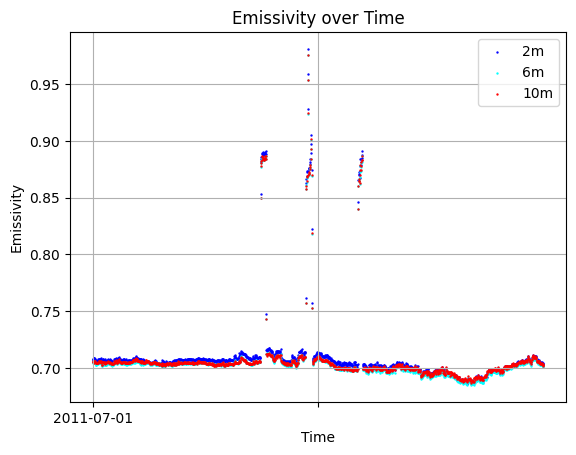

In [47]:
## Plot e_sky over time
plt.scatter(df.index[epsmask2], df['eps2'][epsmask2], label='2m', s=0.5, color='blue')
plt.scatter(df.index[epsmask6], df['eps6'][epsmask6], label='6m', s=0.5, color='cyan')
plt.scatter(df.index[epsmask10], df['eps10'][epsmask10], label='10m', s=0.5, color='red')

# Set ticks at regular intervals
# Find the start and end dates in your DataFrame
start_date = df.index.min()
end_date = df.index.max()

# # Generate ticks at regular intervals between start and end dates
ticks = pd.date_range(start=start_date, end=end_date, freq='12h')
tick_labels = [date.strftime('%Y-%m-%d') if i % 4 == 0 else None for i, date in enumerate(ticks)]

# Format the plot
plt.xticks(ticks, tick_labels)
plt.xlabel('Time')
plt.ylabel('Emissivity')
plt.title('Emissivity over Time')
plt.legend()
plt.grid()

# Save plot as .png
# plt.savefig('emissivity.png')

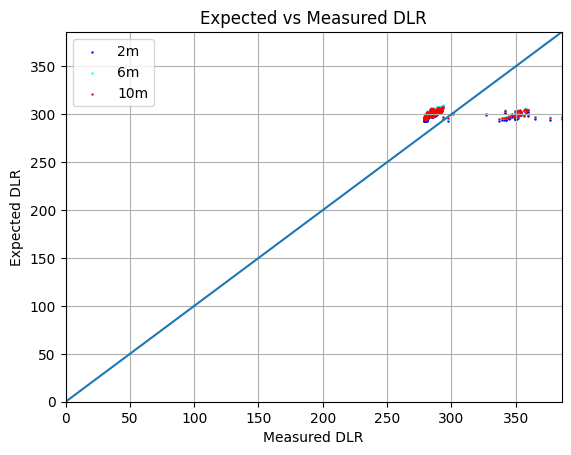

In [39]:
## Plot expected DLR vs measured DLR
plt.scatter(df['LWTotalDownwelling[W/m^2]'][DLRmask2], df['DLR2'][DLRmask2], label='2m', s=0.5, color='blue')
plt.scatter(df['LWTotalDownwelling[W/m^2]'][DLRmask6], df['DLR6'][DLRmask6], label='6m', s=0.5, color='cyan')
plt.scatter(df['LWTotalDownwelling[W/m^2]'][DLRmask10], df['DLR10'][DLRmask10], label='10m', s=0.5, color='red')

# Calculate the maximum value for x and y
max_value = max(np.nanmax(df['LWTotalDownwelling[W/m^2]'][DLRmask2]), np.nanmax(df['DLR2'][DLRmask2]))
plt.xlim(0, max_value)
plt.ylim(0, max_value)
plt.grid()
plt.plot([0,max_value],[0,max_value])

# Format the plot
plt.xlabel('Measured DLR')
plt.ylabel('Expected DLR')
plt.title('Expected vs Measured DLR')
plt.legend()

# Save plot as .png
# plt.savefig('exp-vs-measured-DLR.png')

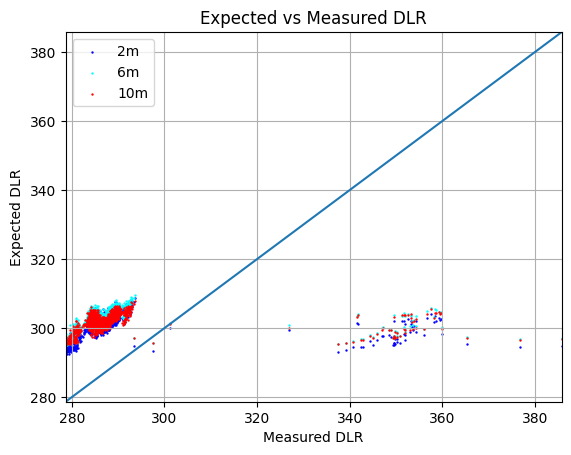

In [49]:
## Plot expected DLR vs measured DLR
plt.scatter(df['LWTotalDownwelling[W/m^2]'][DLRmask2], df['DLR2'][DLRmask2], label='2m', s=0.5, color='blue')
plt.scatter(df['LWTotalDownwelling[W/m^2]'][DLRmask6], df['DLR6'][DLRmask6], label='6m', s=0.5, color='cyan')
plt.scatter(df['LWTotalDownwelling[W/m^2]'][DLRmask10], df['DLR10'][DLRmask10], label='10m', s=0.5, color='red')

# Calculate the maximum value for x and y
max_value = max(np.nanmax(df['LWTotalDownwelling[W/m^2]'][DLRmask2]), np.nanmax(df['DLR2'][DLRmask2]))
min_value = min(np.nanmin(df['LWTotalDownwelling[W/m^2]'][DLRmask2]), np.nanmin(df['DLR2'][DLRmask2]))
plt.xlim(min_value, max_value)
plt.ylim(min_value, max_value)
plt.grid()
plt.plot([min_value,max_value],[min_value,max_value])


# Format the plot
plt.xlabel('Measured DLR')
plt.ylabel('Expected DLR')
plt.title('Expected vs Measured DLR')
plt.legend()

# Save plot as .png
# plt.savefig('exp-vs-measured-DLR.png')